In [19]:
import requests
import numpy as np
import pandas as pd
import math
import aiohttp
import httpx
import asyncio
import ujson as json
from datetime import datetime
import time
import os
import sys
import matplotlib.pyplot as plt
from typing import List, Optional, Dict, TypeAlias
JSON: TypeAlias = dict[str, "JSON"] | list["JSON"] | str | int | float | bool | None

from dotenv import load_dotenv
load_dotenv()

from CUSIP_Curve import CUSIP_Curve
from CurveInterpolator import CurveInterpolator

import nest_asyncio
nest_asyncio.apply()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def temp_tester_httpx(start, end, cusips):
    async def build_tasks(client: httpx.AsyncClient, start, end, cusips):
        tasks = await CUSIP_Curve._build_fetch_tasks_historical_trace_data(client=client, cusips=cusips, start_date=start, end_date=end)
        return await asyncio.gather(*tasks)
    
    async def run_fetch_all(start, end, cusips):
        async with httpx.AsyncClient() as client:
            all_data = await build_tasks(client=client, cusips=cusips, start=start, end=end)
            return all_data

    results = asyncio.run(run_fetch_all(cusips=cusips, start=start, end=end))
    return results

def temp_tester_aio(start, end, cusips):
    async def build_tasks(session: aiohttp.ClientSession, start, end, cusips):
        tasks = await CUSIP_Curve._build_fetch_tasks_historical_trace_data(session=session, cusips=cusips, start_date=start, end_date=end)
        return await asyncio.gather(*tasks)
    
    async def run_fetch_all(start, end, cusips):
        async with aiohttp.ClientSession() as session:
            all_data = await build_tasks(session=session, cusips=cusips, start=start, end=end)
            return all_data

    results = asyncio.run(run_fetch_all(cusips=cusips, start=start, end=end))
    return results

In [ ]:
# CUSIP_Curve(debug_verbose=True).fetch_historcal_trace_trade_history_by_cusip(
#     cusips=["912810UA4"],
#     start_date=datetime(2024, 7, 29),
#     end_date=datetime(2024, 8, 2),
#     # xlsx_path="trace_trade_history_may54s.xlsx",
# )

In [2]:
as_of_date = datetime(2024, 8, 15)
cusip_curve_builder = CUSIP_Curve(no_logs_plz=True, use_ust_issue_date=True)
auctions_df = cusip_curve_builder.get_auctions_df(as_of_date=as_of_date)

In [3]:
df = cusip_curve_builder.build_curve_set(
    as_of_date=as_of_date,
    calc_ytms=True,
    # use_quantlib=True,
    # include_auction_results=True,
    # include_soma_holdings=True,
    # include_stripping_activity=True,
    auctions_df=auctions_df,
    sorted=True,
)
df

,cusip,security_type,auction_date,issue_date,maturity_date,time_to_maturity,int_rate,high_investment_rate,is_on_the_run,label,original_security_term,offer_price,bid_price,eod_price,mid_price,offer_yield,bid_yield,eod_yield,mid_yield
0,912797KY2,Bill,2024-04-17,2024-04-23,2024-08-20,0.013699,NaN,5.406000,False,Aug 24s,17-Week,0.000000,99.927222,0.0,49.963611,NaN,6.736164,NaN,NaN
1,912797KZ9,Bill,2024-04-24,2024-04-30,2024-08-27,0.032877,NaN,5.406000,False,Aug 24s,17-Week,99.825333,99.825000,0.0,99.825166,5.869420,5.880783,NaN,5.875101
2,912797LA3,Bill,2024-05-01,2024-05-07,2024-09-03,0.052055,NaN,5.412000,False,Sep 24s,17-Week,99.724236,99.723972,0.0,99.724104,5.726068,5.731635,NaN,5.728851
3,912797LG0,Bill,2024-05-08,2024-05-14,2024-09-10,0.071233,NaN,5.406000,False,Sep 24s,17-Week,99.621917,99.621556,0.0,99.621736,5.654384,5.659869,NaN,5.657127
4,912797LH8,Bill,2024-05-15,2024-05-21,2024-09-17,0.090411,NaN,5.401000,False,Sep 24s,17-Week,99.519667,99.518750,0.0,99.519208,5.614501,5.625395,NaN,5.619948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,912810TV0,Bond,2023-11-09,2023-11-15,2053-11-15,29.271233,4.750,NaN,False,Nov 53s,30-Year,109.328125,109.312500,0.0,109.320312,4.193092,4.193967,958.505957,4.193530
395,912810TX6,Bond,2024-02-08,2024-02-15,2054-02-15,29.523288,4.250,NaN,False,Feb 54s,30-Year,100.734375,100.718750,0.0,100.726562,4.206280,4.207205,10021.407266,4.206742
396,912810TX6,Bond,2024-03-13,2024-03-15,2054-02-15,29.523288,4.250,NaN,False,Feb 54s,30-Year,100.734375,100.718750,0.0,100.726562,4.206280,4.207205,10021.407266,4.206742
397,912810UA4,Bond,2024-05-09,2024-05-15,2054-05-15,29.767123,4.625,NaN,False,May 54s,30-Year,107.234375,107.218750,0.0,107.226562,4.196562,4.197442,958.505957,4.197002


c:\Users\chris\Curvy-CUSIPs\server\CurveInterpolator.py:185: RuntimeWarning: divide by zero encountered in log
  log_linspace_x = np.log(self._linspace_x)


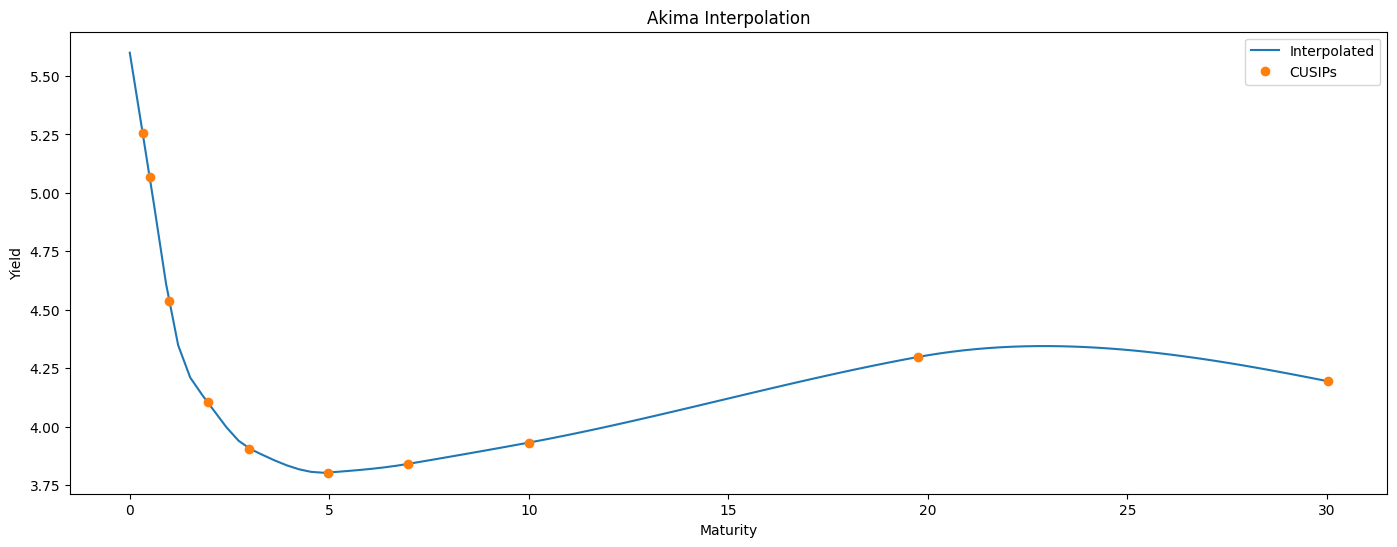

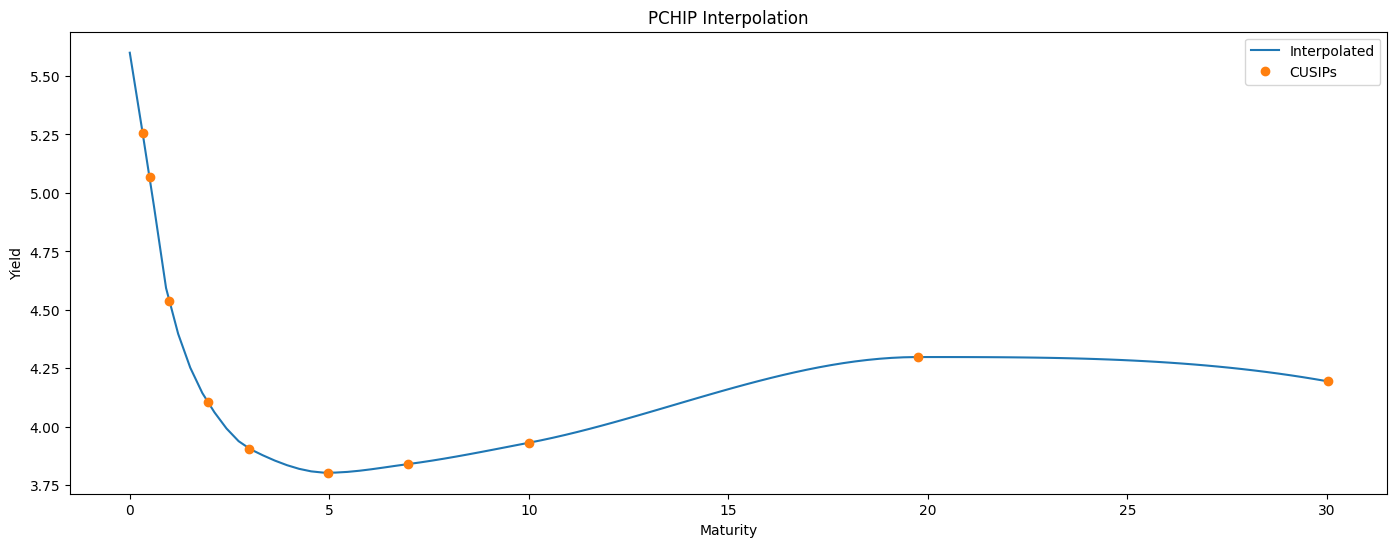

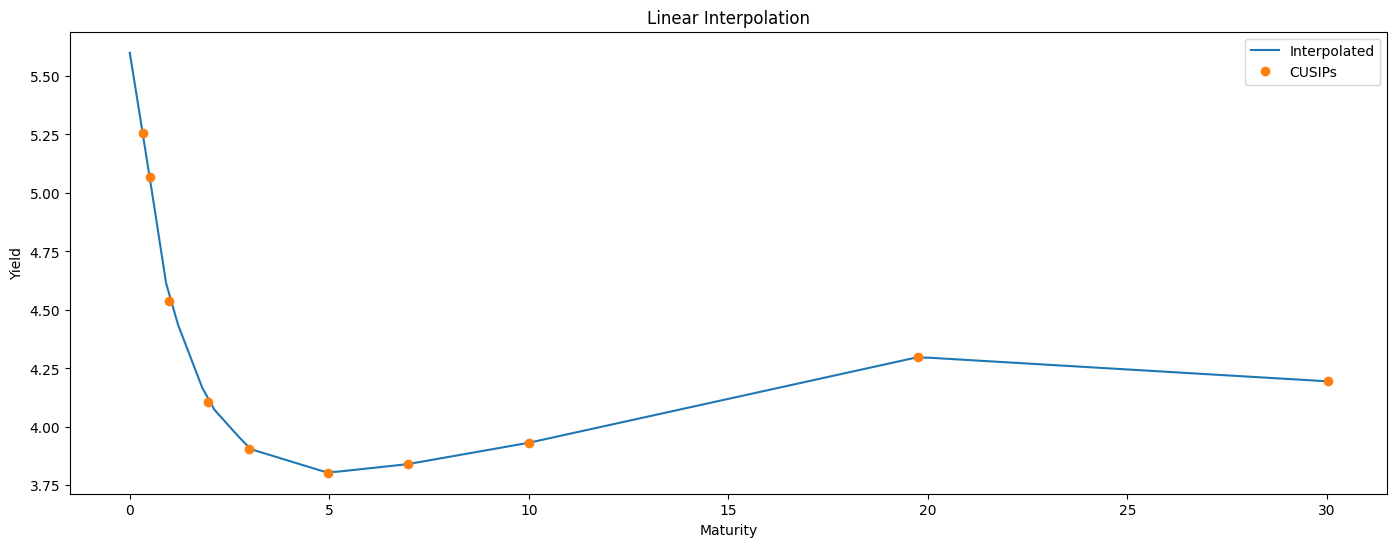

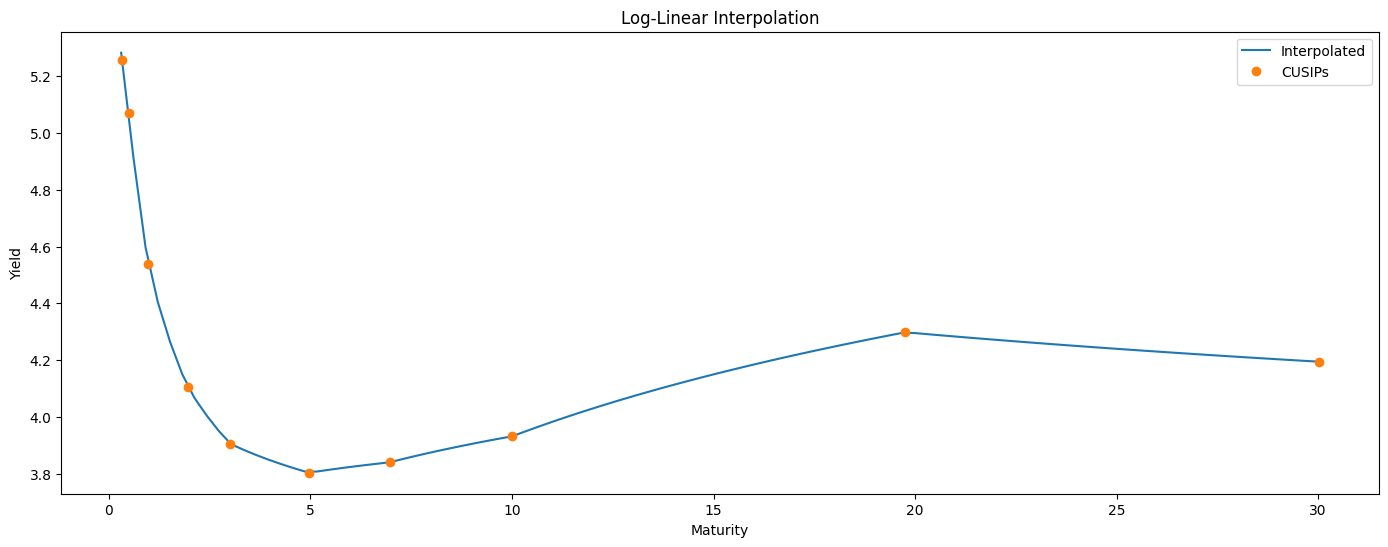

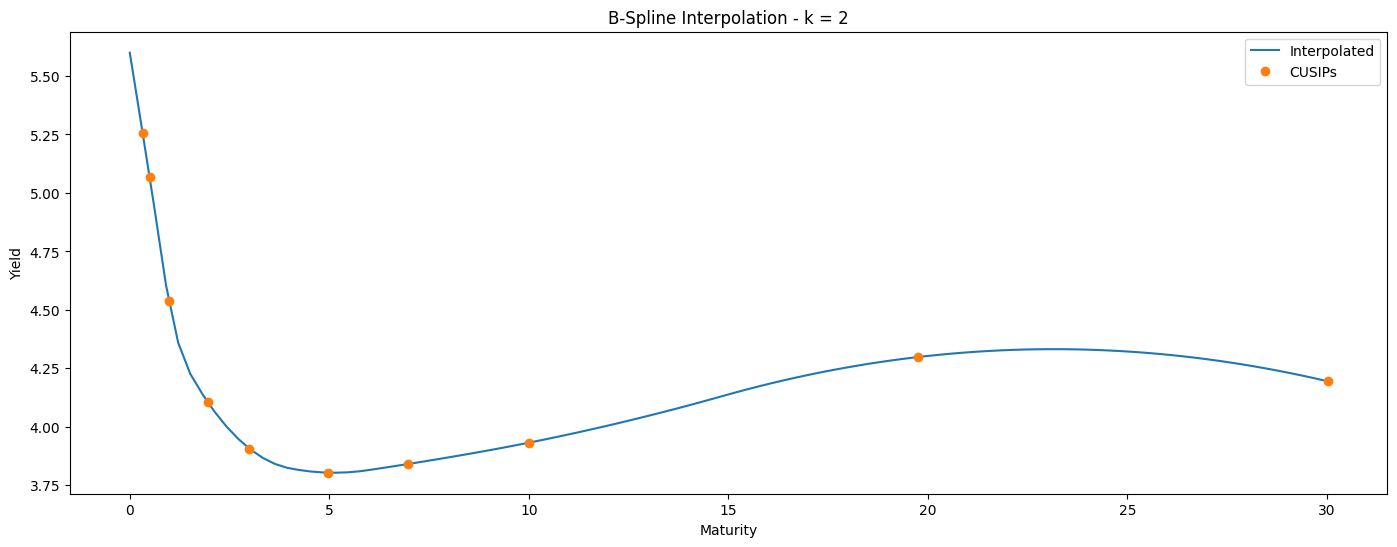

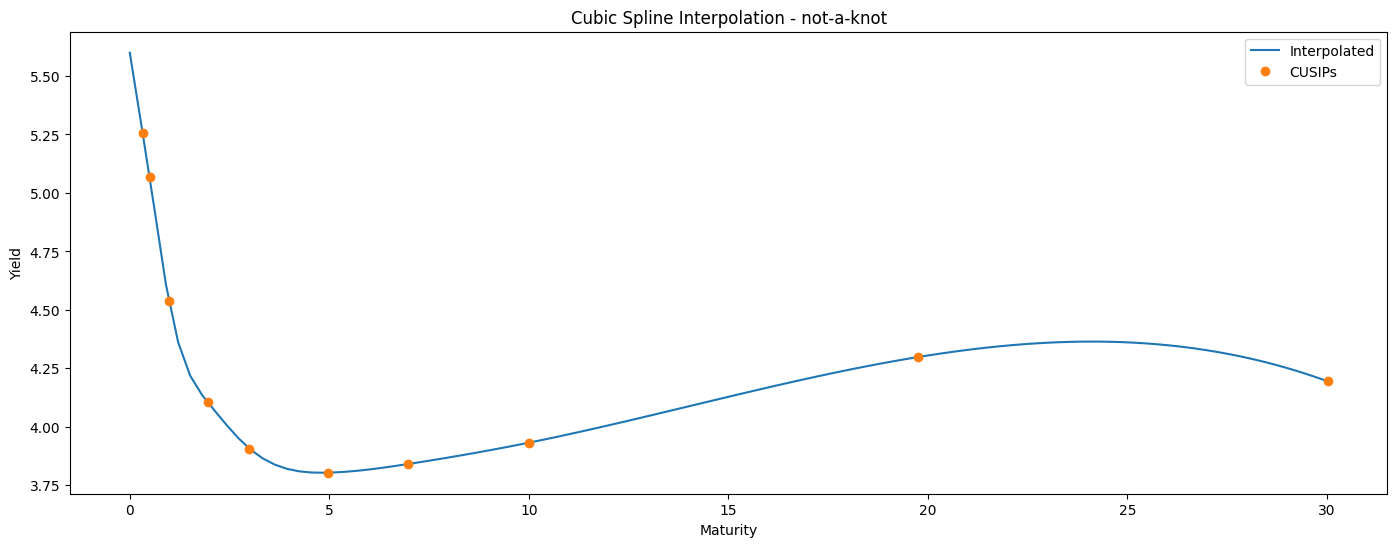

In [39]:
interpolator = CurveInterpolator(
    curve_set_df=df[df["is_on_the_run"] == True],
    linspace_x_num=100,
    enable_extrapolate_left_fill=True,
    enable_extrapolate_right_fill=True,
    use_bid_side=True
)

# interpolator.set_cubic_spline_interpolation_bc_type(bc_type="natural")
# interpolator.set_cubic_spline_interpolation_custom_knots(custom_knots=np.array([15, 17, 22]))
# interpolator.set_cubic_spline_interpolation_nu(nu=0)
interpolator.set_b_spline_k(2)
interpolator.plotter(
    linear=True, 
    log_linear=True, 
    cubic=True, 
    pchip=True, 
    akima=True,
    b_spline=True, 
    run_parallel=True,
    # cubic_bc_types_n_knots_n_nu=[("natural", np.array([]), 0)]
)

In [45]:
df[df["is_on_the_run"] == True]["bid_yield"].to_list()

[5.258047907623223,
 5.068313806703524,
 4.538977465708812,
 4.104248469556026,
 3.906360694376456,
 3.8039494327325727,
 3.8405160868389356,
 3.9321489548631066,
 4.298374133968205,
 4.1947433231346425]

In [40]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [30]:
from models.calibrate import calibrate_ns_ols, calibrate_nss_ols, calibrate_bc_ols, calibrate_bc_augmented_ols, calibrate_diebold_li_ols 
from models.MonotoneConvex import MonotoneConvex

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


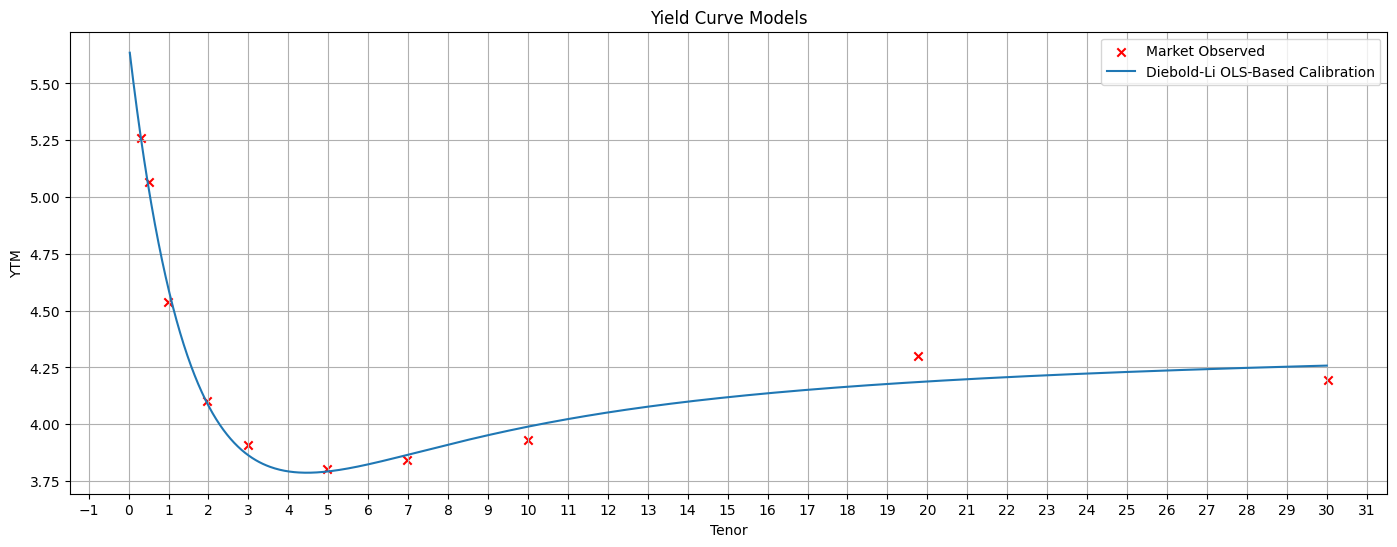

In [34]:
maturities = np.array(
    [
        0.32054794520547947,
        0.4986301369863014,
        0.9780821917808219,
        1.9589041095890412,
        3.0,
        4.961643835616439,
        6.961643835616439,
        10.005479452054795,
        19.76164383561644,
        30.019178082191782,
    ]
)

yields = np.array(
    [
        5.258047907623223,
        5.068313806703524,
        4.538977465708812,
        4.104248469556026,
        3.906360694376456,
        3.8039494327325727,
        3.8405160868389356,
        3.9321489548631066,
        4.298374133968205,
        4.1947433231346425,
    ]
)

curve_ns, status_ns = calibrate_ns_ols(
    maturities,
    yields,
    tau0=1.0,
)
assert status_ns.success

curve_nss, status_nss = calibrate_nss_ols(
    maturities,
    yields,
)
assert status_nss.success

curve_bc, status_bc = calibrate_bc_ols(maturities, yields)
assert status_bc.success

curve_bca, status_bca = calibrate_bc_augmented_ols(maturities, yields)
assert status_bca.success

curve_di, status_di = calibrate_diebold_li_ols(maturities, yields)
assert status_di.success


t2 = np.linspace(0, 30, 1000)
plt.figure(figsize=(17, 6))
plt.scatter(
    maturities,
    yields,
    marker="x",
    color="red",
    label="Market Observed",
)
# plt.plot(t2, curve_ns(t2), "b-", label="NS OLS-Based-Calibration")
# plt.plot(t2, curve_nss(t2), "g-", label="NSS OLS-Based-Calibration")
# plt.plot(t2, curve_bc(t2), label="Bjork-Christensen OLS-Based Calibration")
# plt.plot(t2, [mc.spot(t) for t in t2], label="mc")
# plt.plot(t2, curve_bca(t2), label="Bjork-Christensen-Augmented OLS-Based Calibration")
plt.plot(t2, curve_di(t2), label="Diebold-Li OLS-Based Calibration")

plt.title("Yield Curve Models")
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("Tenor")
plt.ylabel("YTM")
plt.grid(True)
plt.legend()
plt.show()